In [378]:
import pandas as pd
import numpy as np
import plotly.express as px
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm
import copy

In [5]:
train =  pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Exploring the data

In [ ]:
train = train.set_index("Id")
test = test.set_index("Id"

In [47]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

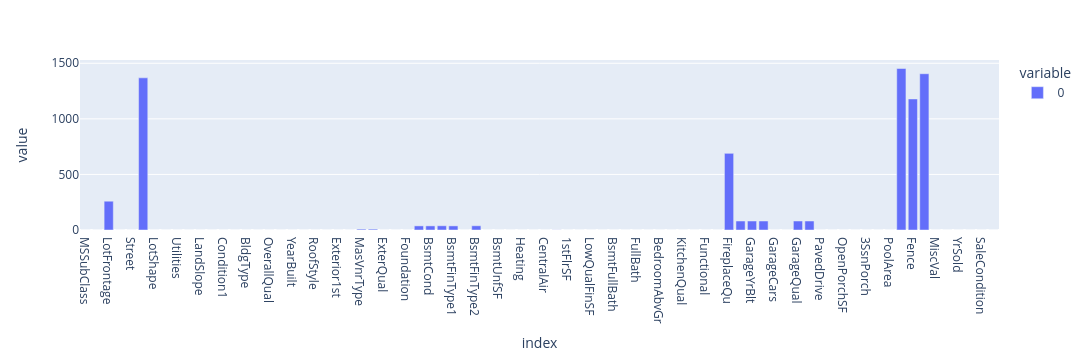

In [42]:
fig = px.bar(train.isna().sum())
fig.show();

In [45]:
train[train["Alley"].isna() != True]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal,139400
31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
57,160,FV,24.0,2645,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,WD,Abnorml,172500
80,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,5,2009,WD,Normal,110000
88,160,FV,40.0,3951,Pave,Pave,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,164500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,50,RL,60.0,10410,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,1,2006,WD,Family,105000
1415,50,RL,64.0,13053,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,207000
1428,50,RL,60.0,10930,Pave,Grvl,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,140000


/tmp/ipykernel_12098/834525122.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



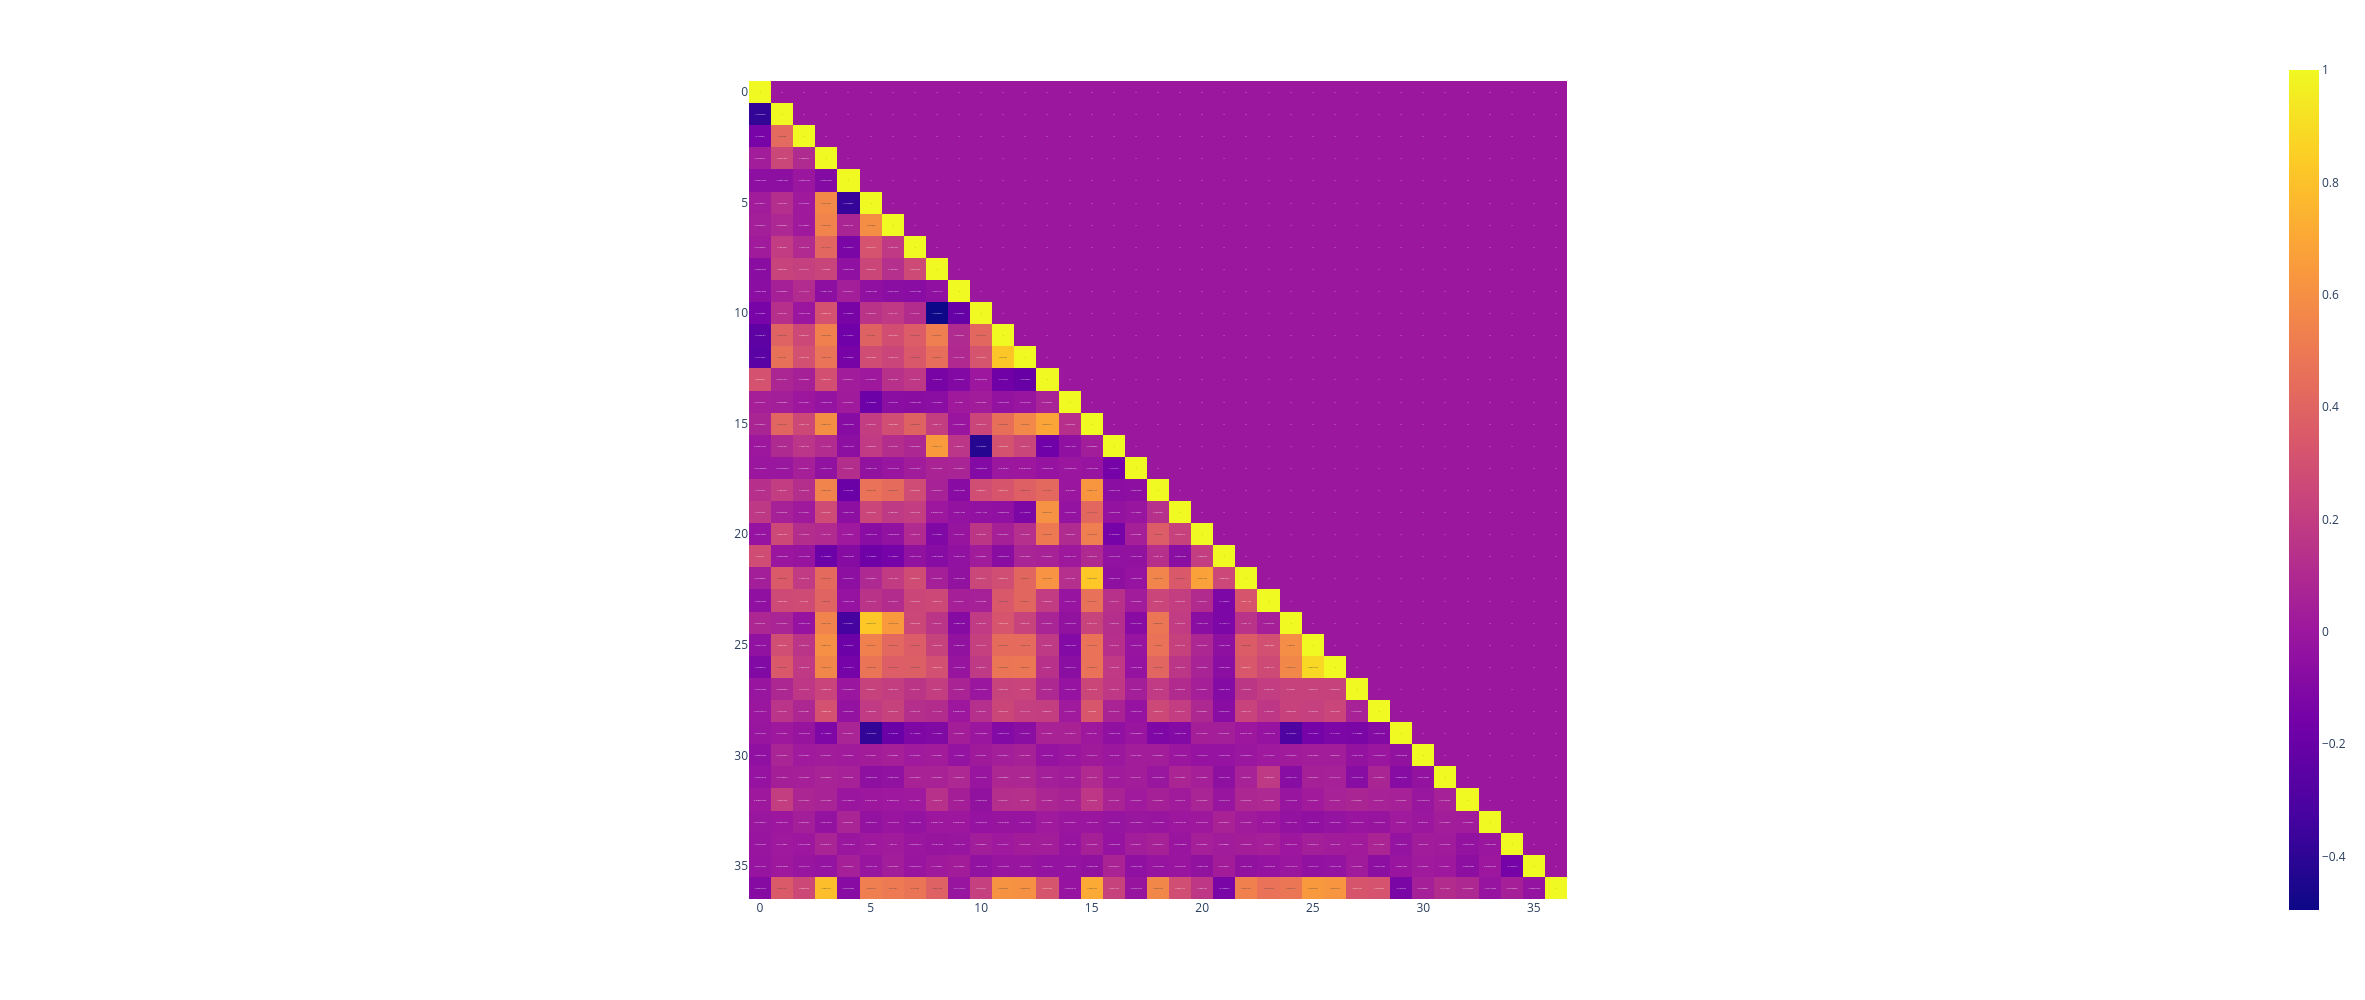

In [34]:
fig = px.imshow(np.tril(train.corr()), text_auto=True, width=1000, height=1000)
fig.show()

## Preprocessing the data

In [87]:
categorical_columns = train.select_dtypes(include=["object", "category"]).columns 
numerical_columns = train.select_dtypes(include=["int64", "float64"]).columns
numerical_columns = numerical_columns.drop("SalePrice")

In [90]:
cat_transofrmer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
numerical_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

In [91]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numerical_transformer, numerical_columns),
        ("categorical", cat_transofrmer, categorical_columns)
    ], remainder= "passthrough")
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])
X = train.drop("SalePrice", axis=1)
y = np.log(train["SalePrice"])
X_preprocessed = pipeline.fit_transform(X)

In [391]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

## Defining the models

In [392]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}
param_grids = {
    'logisticgRegression': {
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'C': [100, 10, 1.0, 0.1, 0.01]
    },
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10],
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10],
    }
}

In [393]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
grids_fe = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids_fe[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grids_fe[model_name].fit(X_train, y_train)
    best_params = grids_fe[model_name].best_params_
    best_score = np.sqrt(-1 * grids_fe[model_name].best_score_)
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best RMSE for {model_name}: {best_score}\n')

Training and tuning LinearRegression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters for LinearRegression: {}
Best RMSE for LinearRegression: 13999314035.548674

Training and tuning RandomForest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best RMSE for RandomForest: 0.1531205076608245

Training and tuning XGBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best RMSE for XGBoost: 0.13224865853855566



In [394]:
test_processed = pipeline.transform(test)

In [395]:
test_processed

array([[-0.87256276,  0.38150799,  0.11076257, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87256276,  0.42362277,  0.37584985, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07337496,  0.12881931,  0.33205282, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.87256276,  3.75069043,  0.95042275, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66458604, -0.37655806, -0.00759964, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07337496,  0.12881931, -0.08918038, ...,  0.        ,
         1.        ,  0.        ]])

In [396]:
submission = grids_fe["XGBoost"].predict(test_processed)

In [397]:
submission = pd.DataFrame({"Id": test["Id"], "SalePrice": submission})

In [398]:
submission

,Id,SalePrice
0,1461,11.723750
1,1462,11.995175
2,1463,12.135003
3,1464,12.151325
4,1465,12.194177
...,...,...
1454,2915,11.310620
1455,2916,11.301927
1456,2917,11.870982
1457,2918,11.656639


In [399]:
submission["SalePrice"] = submission["SalePrice"].apply(lambda x: np.exp(x))

In [400]:
submission

,Id,SalePrice
0,1461,123469.583151
1,1462,161971.449598
2,1463,186279.421193
3,1464,189344.848330
4,1465,197634.901137
...,...,...
1454,2915,81684.562371
1455,2916,80977.499641
1456,2917,143054.673753
1457,2918,115455.343651


In [401]:
submission.to_csv("submission.csv", index=False)

## Deep Neural network

In [402]:
X_train.shape

(1168, 304)

In [403]:
input_size = 304
learning_rate = 0.001
batch_size = 64
num_epochs = 100
batch_start = torch.arange(0, len(X_train), batch_size)

In [404]:
class NN(nn.Module):
    def __init__(self, input_size): 
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 150)
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [405]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [406]:
model = NN(input_size=304)
model = model.to(device=device)

In [407]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [408]:
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 1)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 1)

In [409]:
X_train = X_train.to(device=device)
y_train = y_train.to(device=device)
X_test = X_test.to(device=device)
y_test = y_test.to(device=device)

In [410]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
for epoch in range(num_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            X_batch = X_batch.to(device=device)
            y_batch = y_batch.to(device=device)
            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = criterion(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

MSE: 0.02
RMSE: 0.14


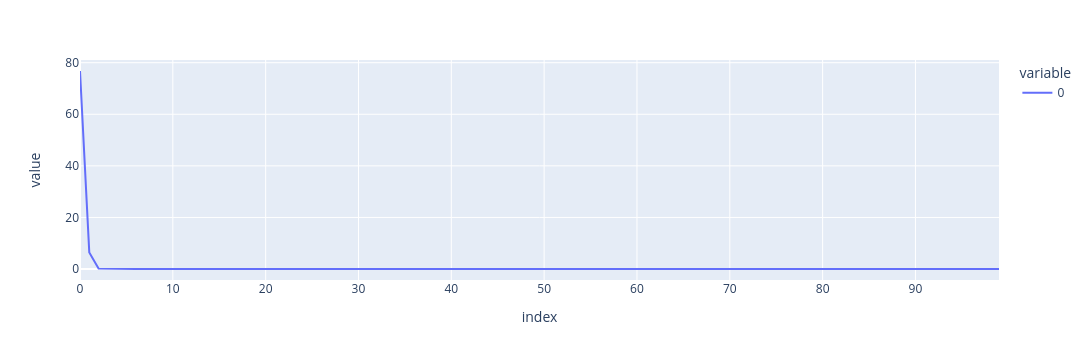

In [411]:
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
fig = px.line(history)
fig.show()